<center>

*******************************************************************************************
<font size="4">
Kuramoto <i>r</i> &nbsp; &nbsp; <br>
</font>

##### 20 September 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* The Kuramoto order parameter *r* measures phase coherence (closeness) amongst two or more oscillators.
>
* Tested with:
    * Python 3.11
    * Windows 11
>
* References:
    * Strogatz, S. H. (2000). From Kuramoto to Crawford: exploring the onset of synchronization in populations of coupled oscillators. *Physica D: Nonlinear Phenomena, 143*(1-4), 1-20.
    * https://github.com/fabridamicelli/kuramoto
>
* Instructions:
    * Edit the values indicated with an arrow like this: <---

*******************************************************************************************

In [1]:
import sys
import numpy as np

sys.path.append('../src')
import syncoord as sc

***
### Generate synthetic data

index; key; Name; duration (s):
  0; 0; Test Data; 0:16.0


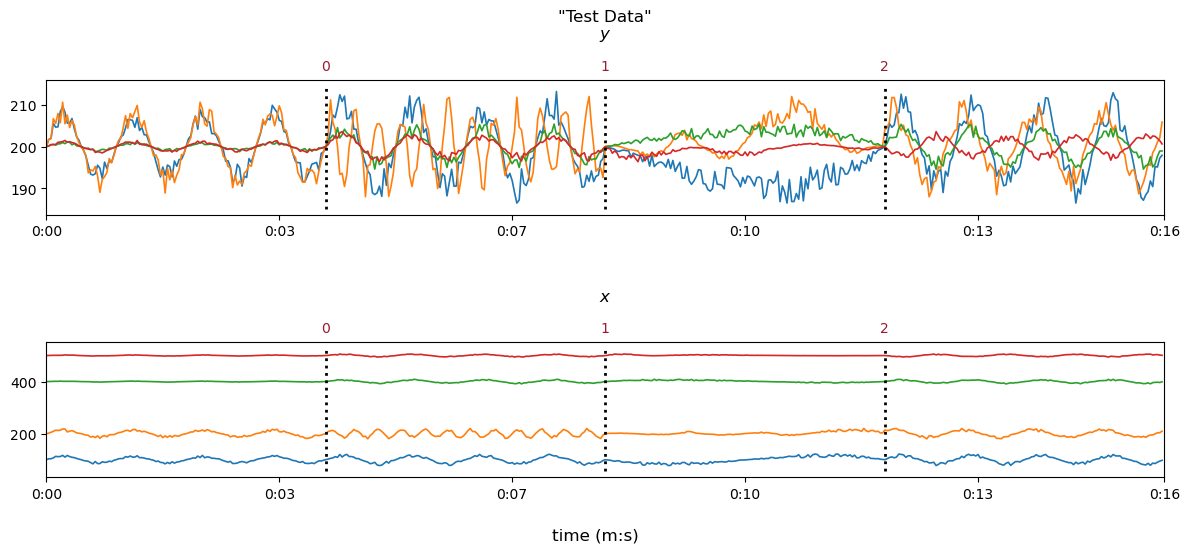

In [2]:
base_freq = 1     # <--- baseline frequency (Hz)
shuffseed = None  # <--- None = don't shuffle sections, int = shuffle sections

testdata_vars = sc.utils.init_testdatavars(seed=1)
testdata_vars['point_vars'][[0,1,3],...,0] = base_freq
testdata_vars['point_vars'][1,1,...,0] = base_freq * 3
if shuffseed is not None:
    rangen = np.random.default_rng(seed=shuffseed)
    rangen.shuffle(testdata_vars['point_vars'])
test_data_1 = sc.ptdata.load( testdata_vars, print_info=True )
test_data_1.visualise( vscale=1.2, dlattr='1.2' )

Unshuffled sections:
>0. All synchronised at baseline frequency, but signals 0 and 1 have higher amplitude.
>1. As in section 0, but signal 1 has triple the baseline frequency.
>2. Random oscillation.
>3. All have baseline frequency, but with constant phase differences: 1/8 cycle for signals 0 and 1; 1/2 cycle (*out of phase*) for signals 2 and 3.

Also each signal has distinct random noise.

***
### Low-Pass Filter

In [3]:
apply_LPF = False  # <---

filter_type = 'savgol'                  # <--- 'savgol' or 'butter'
filter_window_size_s = 1/(4*base_freq)  # <--- if 'savgol': window size (seconds)
filter_order = 1                        # <--- filter's order

# filter_type = 'butter'                  # <--- 'savgol' or 'butter'
# filter_freq_response = 'lowpass'        # <--- if 'butter': frequency response
# filter_cutoff_freq = base_freq          # <--- if 'butter': cutoff frequency (Hz)
# filter_order = 3                        # <--- filter's order

if apply_LPF:
    test_data_2 = sc.ptdata.smooth( test_data_1, filter_type=filter_type,
                                    freq_response=filter_freq_response,
                                    window_size=filter_window_size_s, order=filter_order )
    test_data_2.visualise( vscale=1.2, dlattr='1.2'  )
else:
    test_data_2 = test_data_1
    print('Filter not applied.')

Filter not applied.


***
### Reduce to 1 Dimension per point

Methods:
* Norms: the sum of the L1 and L2 norms preserve the shape of the oscillation and is not affected by noise.
* Speed: rectifies oscillation and is affected by noise, leading to artifacts when applying the Fourier Transform.

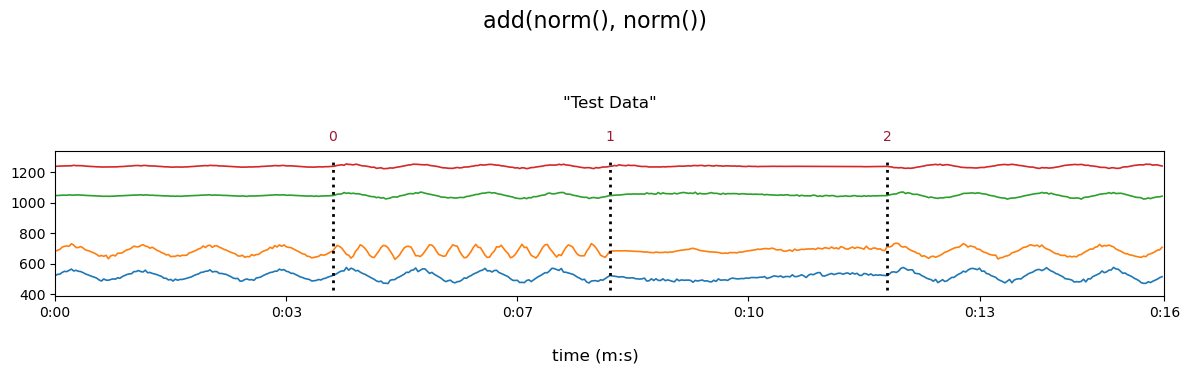

In [4]:
red1D_method = 'norms' # <--- 'norms' or 'speed'

if red1D_method == 'speed':
    test_data_3 = sc.ptdata.speed( test_data_2 )
elif red1D_method == 'norms':
    n1 = sc.ptdata.norm( test_data_2, order=1, axis=-2 )
    n2 = sc.ptdata.norm( test_data_2, order=2, axis=-2 )
    test_data_3 = sc.ptdata.apply2( n1, n2, np.add )
else: raise Exception('invaild value for red1D_method')
test_data_3.visualise( vscale=1.4, dlattr='1.2' )

***
### Phase

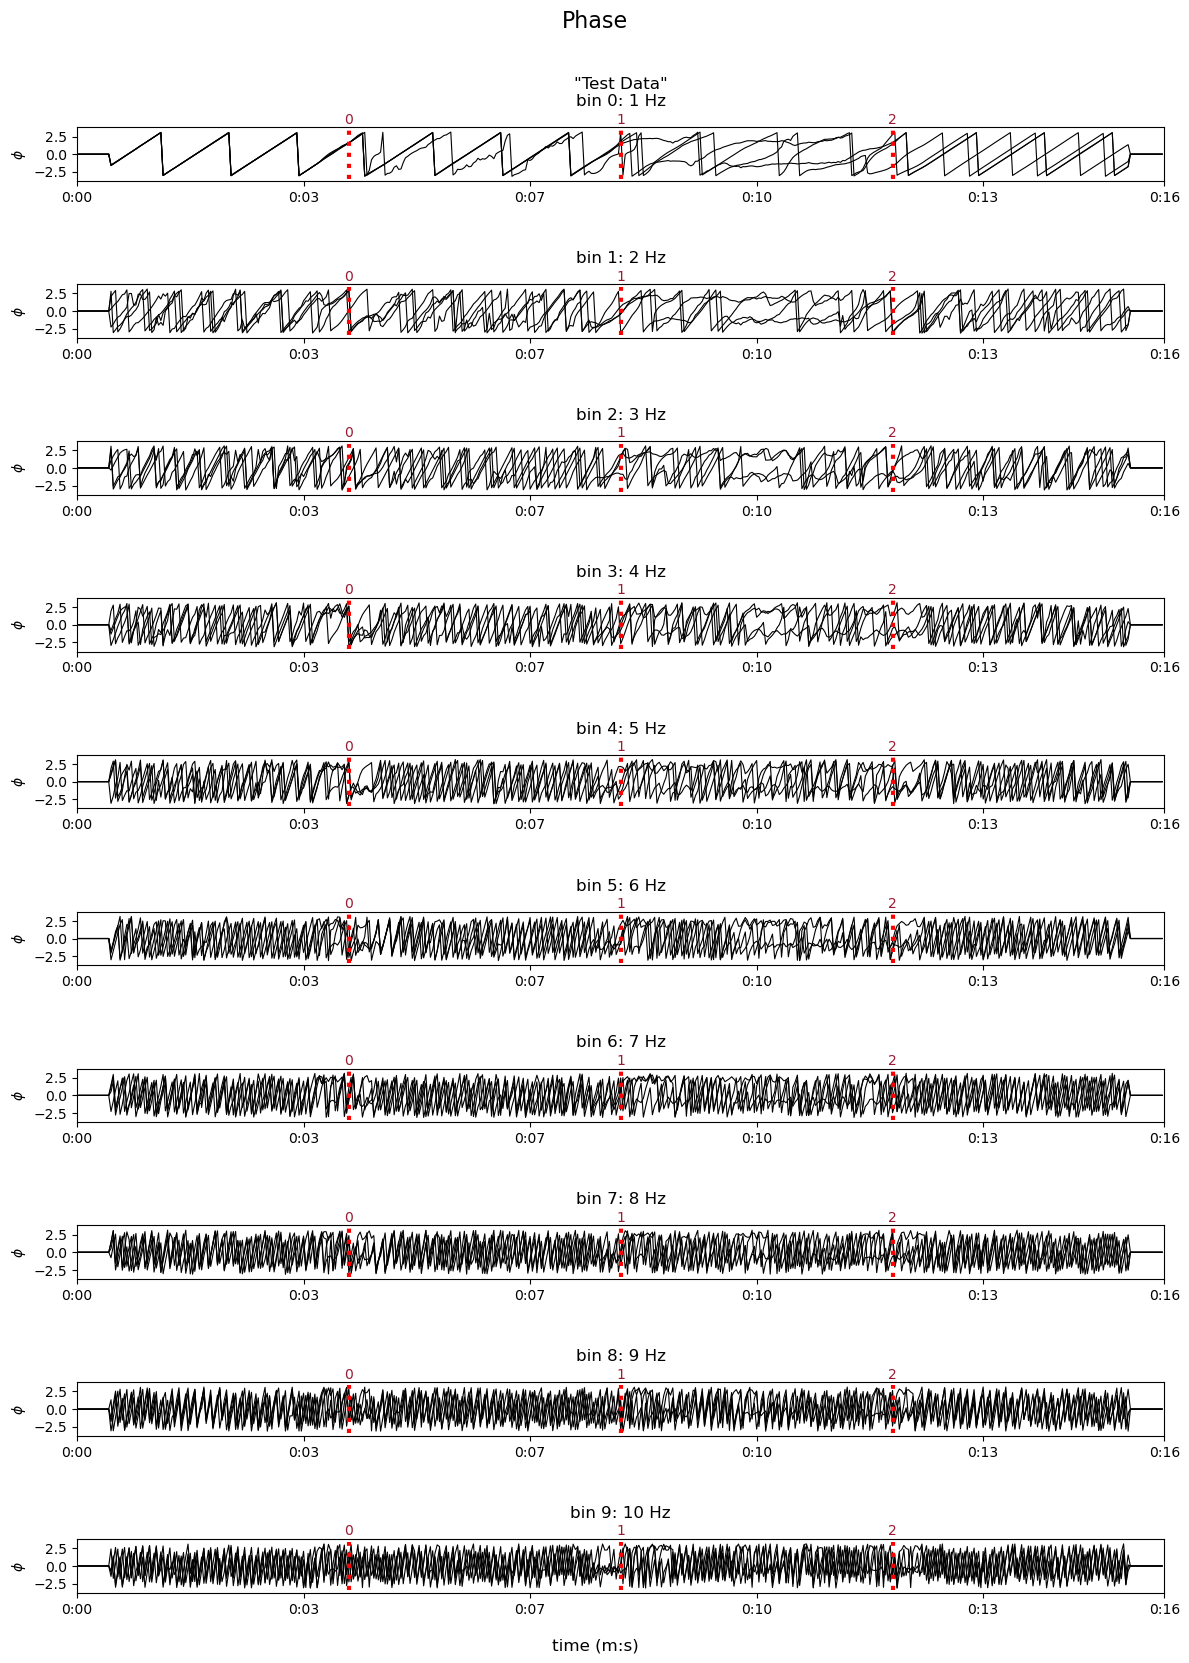

In [5]:
fft_window_s = 1/base_freq  # <--- FFT window's length (seconds)
sel_freq_bin = slice(0,10)  # <--- select frequency bins (int, slice, or 'all')
# sel_freq_bin = 1            # <--- select frequency bins (int, slice, or 'all')

fft_phase = sc.ptdata.fourier( test_data_3, fft_window_s, output='phase' )
if sel_freq_bin == 'all':
    fft_phase.visualise( vscale=0.7 )
else:
    fft_phase = sc.ptdata.select(fft_phase,frequency=sel_freq_bin)
    if isinstance(sel_freq_bin,slice): fft_phase.visualise( vscale=0.7 )
    else: fft_phase.visualise( vscale=1.3 )

***
### Kuramoto Order Parameter *r*

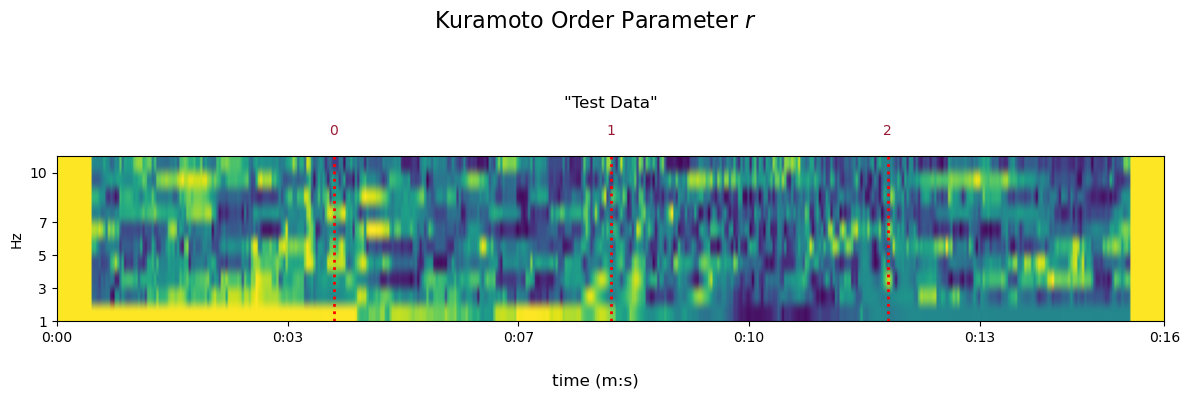

In [6]:
smooth_power = False  # <---

kr_fft = sc.ptdata.kuramoto_r( fft_phase )
kr_fft_vis = kr_fft
if smooth_power:
    kr_fft_s = sc.ptdata.smooth( kr_fft, filter_type='mean', window_size=fft_window_s )
    kr_fft_p = sc.ptdata.apply( kr_fft_s, np.power, 2 )
    kr_fft_vis = kr_fft_p
kr_fft_vis.visualise( vscale=1.5 )

>
#### Band-average for group

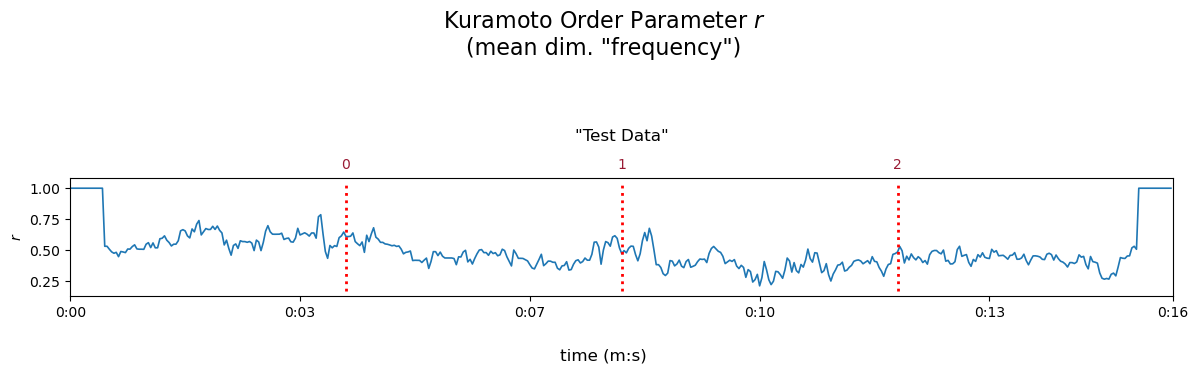

In [7]:
if isinstance(sel_freq_bin,int):
    kr_fft_aggr_top  = kr_fft_vis
    print('Process does not apply.')
else:
    kr_fft_aggr_top = sc.ptdata.aggrax( kr_fft_vis, axis=0, function='mean' )
    kr_fft_aggr_top.visualise( vscale=1.3, vistype='line', dlattr='1.2' )

>
#### Sections' statistics

means = [0.581, 0.442, 0.373, 0.427]


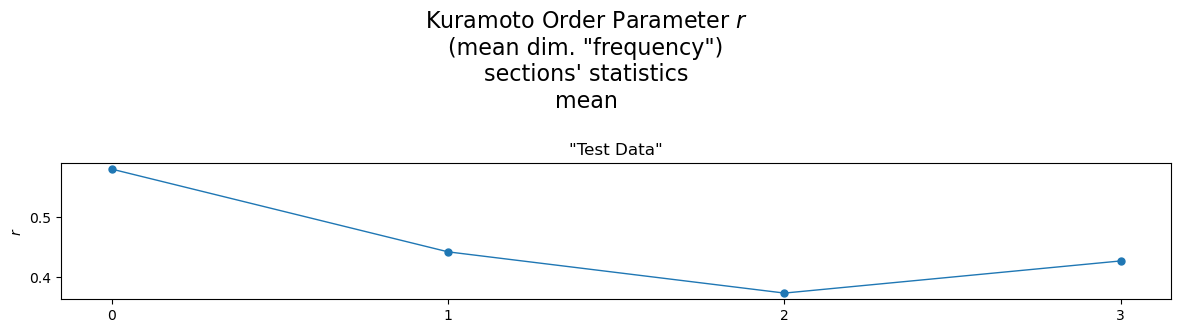

In [8]:

sec_margins = [[fft_window_s/2,fft_window_s/2] for _ in range(4)] # <---sections' margins (seconds)
if smooth_power: sec_margins = [v*2 for v in sec_margins]

kr_fft_aggr_top_stats = sc.ptdata.secstats( kr_fft_aggr_top, margins=sec_margins, last=True )
kr_fft_aggr_top_stats.visualise( statistics='mean', vscale=1.1 )
print('means =','['+', '.join([str(v) for v in np.round(kr_fft_aggr_top_stats.data[0][0],3)])+']')